In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from shared import Db, Fn

from main.ai import ai_setups, zero_setup
from main.data import Mol, data
from main.tree import JsonTree, Tree, TreeTypes
from main.types import AiInput, Setup
from main.score import Score
from main.stats import score_transformer

from IPython.display import display, HTML
from typing import Any

import numpy as np
import pandas
import tabulate
from main.utils import fn_txt


import matplotlib.pyplot as plt


def scatter_plot(pairs_per_plot: list[list[tuple[Any, Any, str]]]):
    fig, axs = plt.subplots(nrows=1, ncols=len(pairs_per_plot), figsize=(16, 3))
    fig.set_dpi(300)
    for i, pairs in enumerate(pairs_per_plot):
        xs = [x for x, _y, _ in pairs]
        ys = [y for _x, y, _ in pairs]
        axs[i].scatter(xs, ys, s=5, linewidths=1)
        axs[i].set_title(pairs[0][2])
    plt.show()


def get_stats(mol: Mol):
    ai_input: AiInput = {"smiles": mol.smiles, "setup": zero_setup}
    json_tree = db.read(["ai_postprocess", ai_input], JsonTree)
    assert json_tree
    tree = Tree(json_tree)
    assert len(tree.expandable) == 1
    assert len(tree.in_stock) == 0
    return tree.expandable[0].score, tree.type, tree.stats()

filters: list[Fn[TreeTypes, bool]] = [
    lambda _type: True,
    lambda type: type == "internal",
    lambda type: type == "not_solved"
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


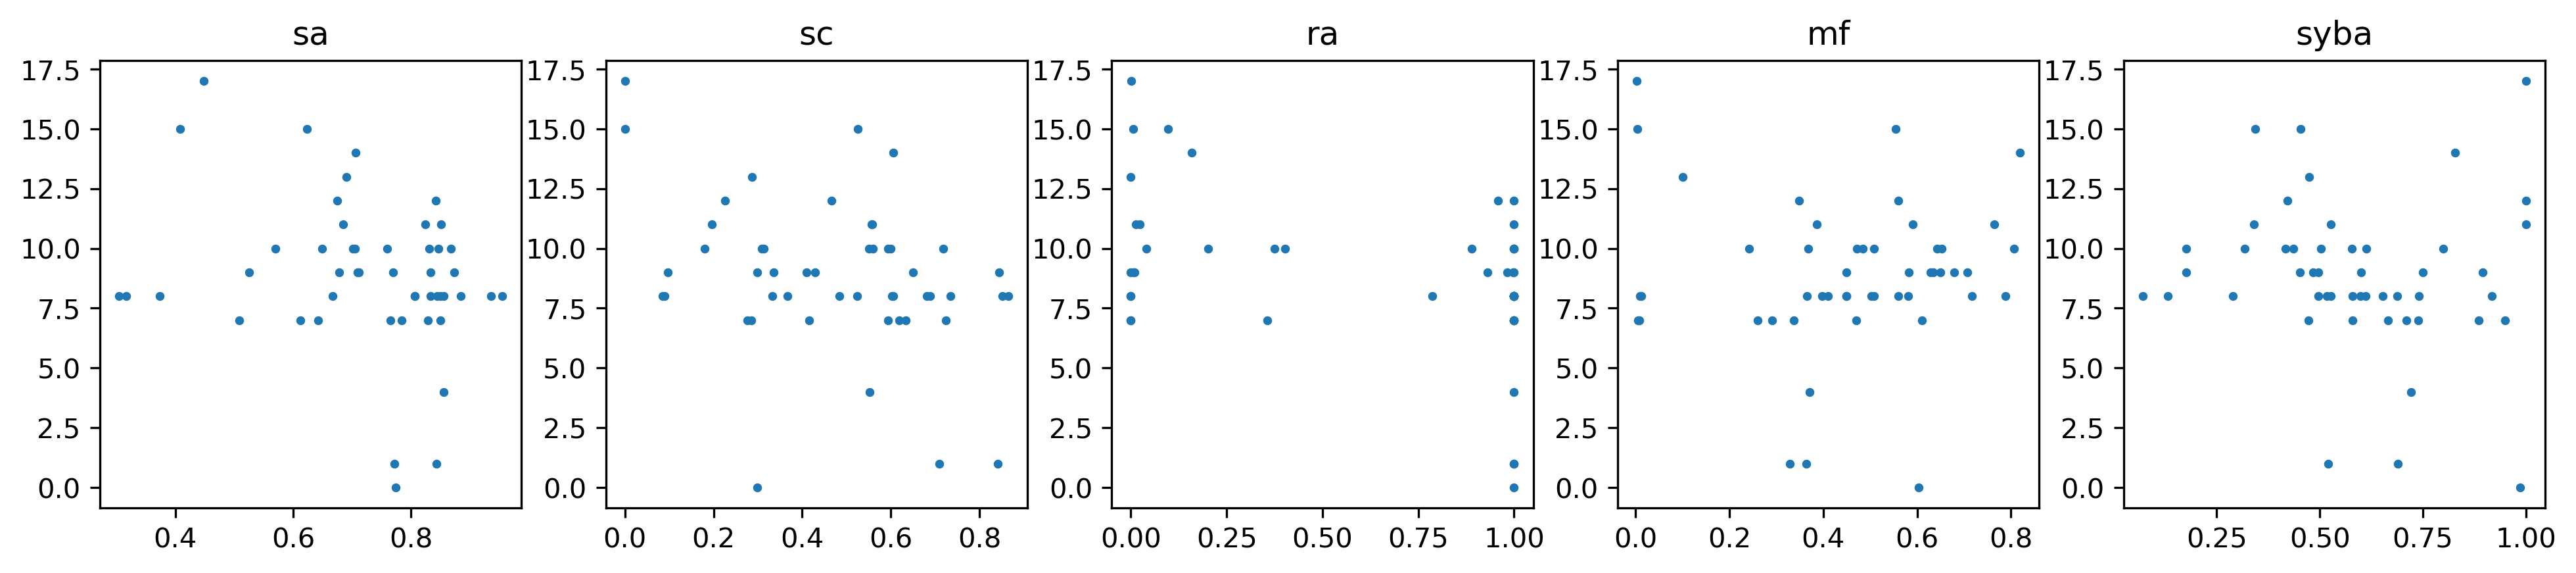

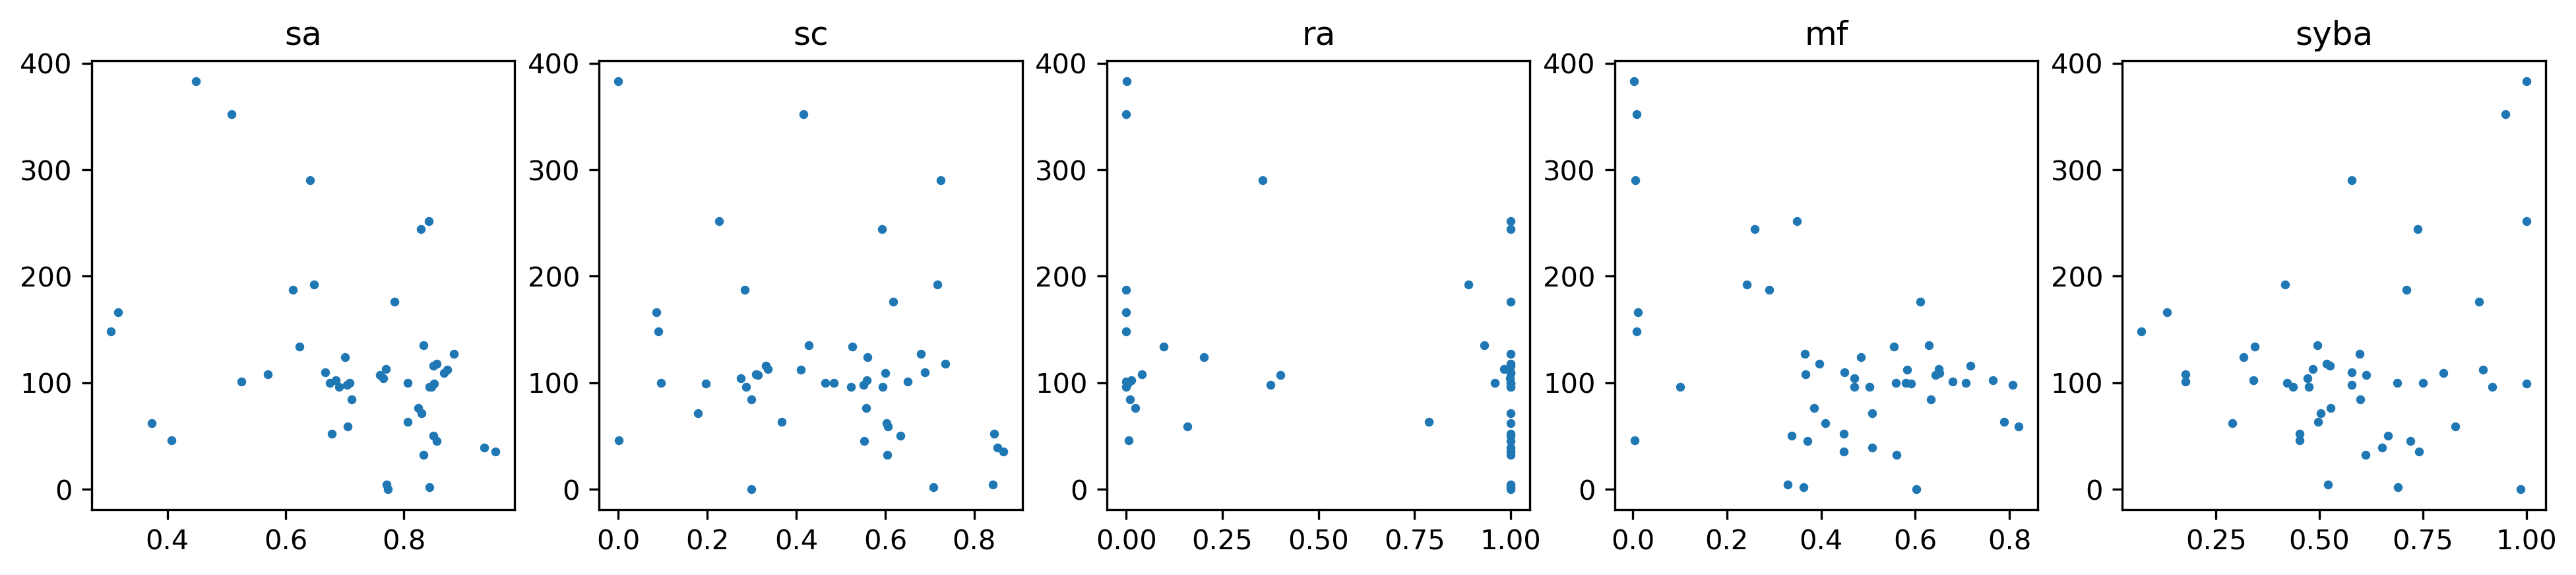

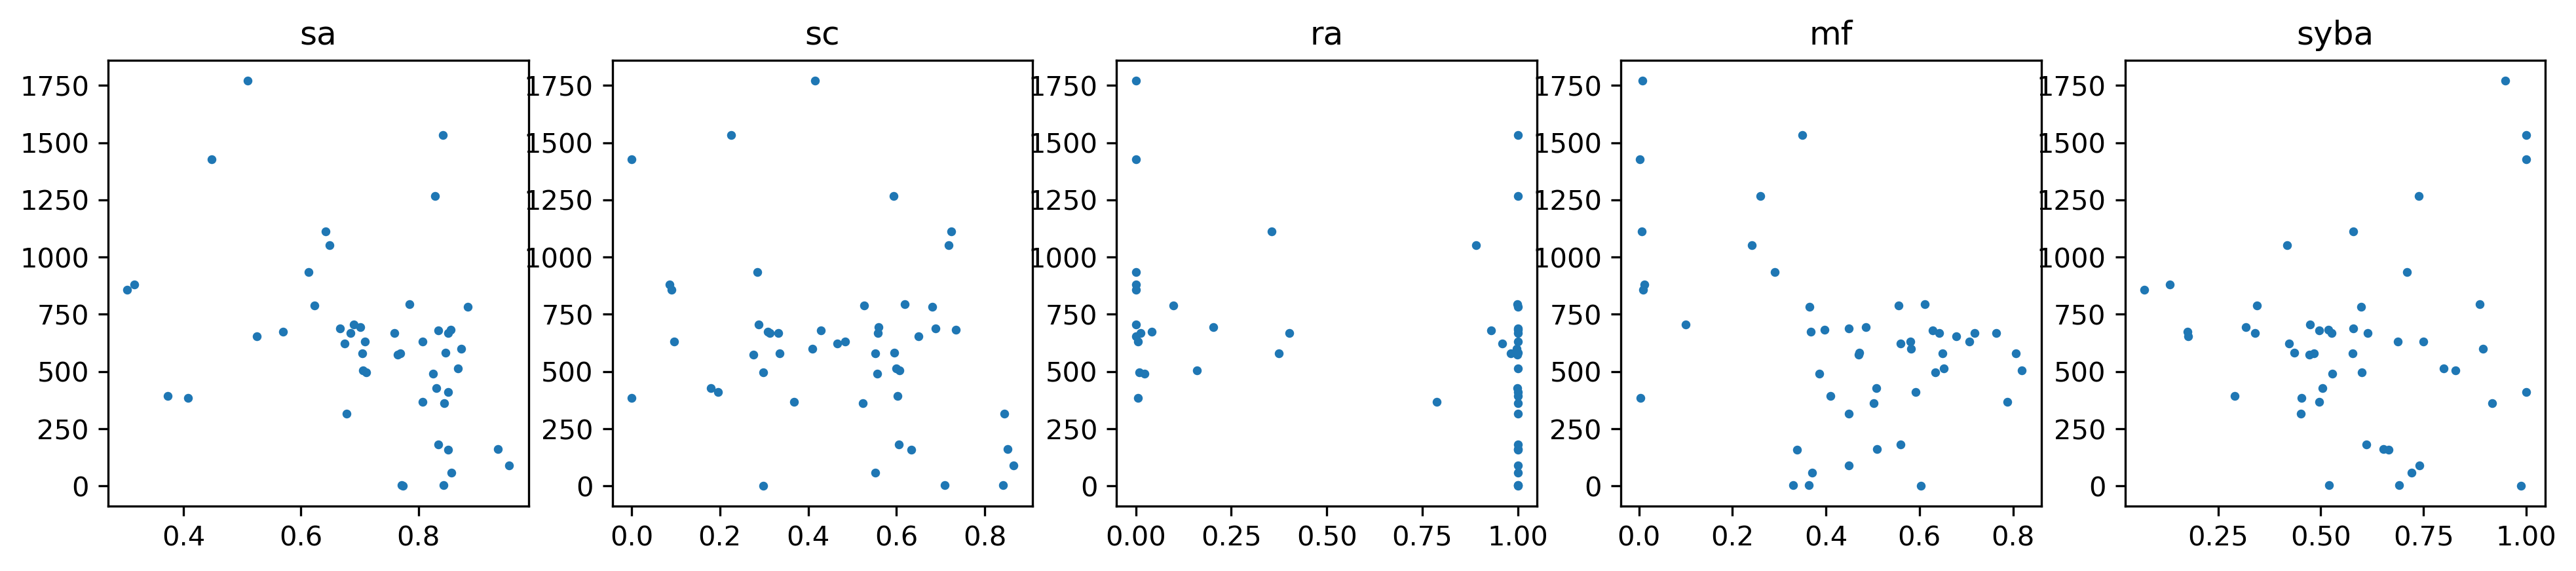

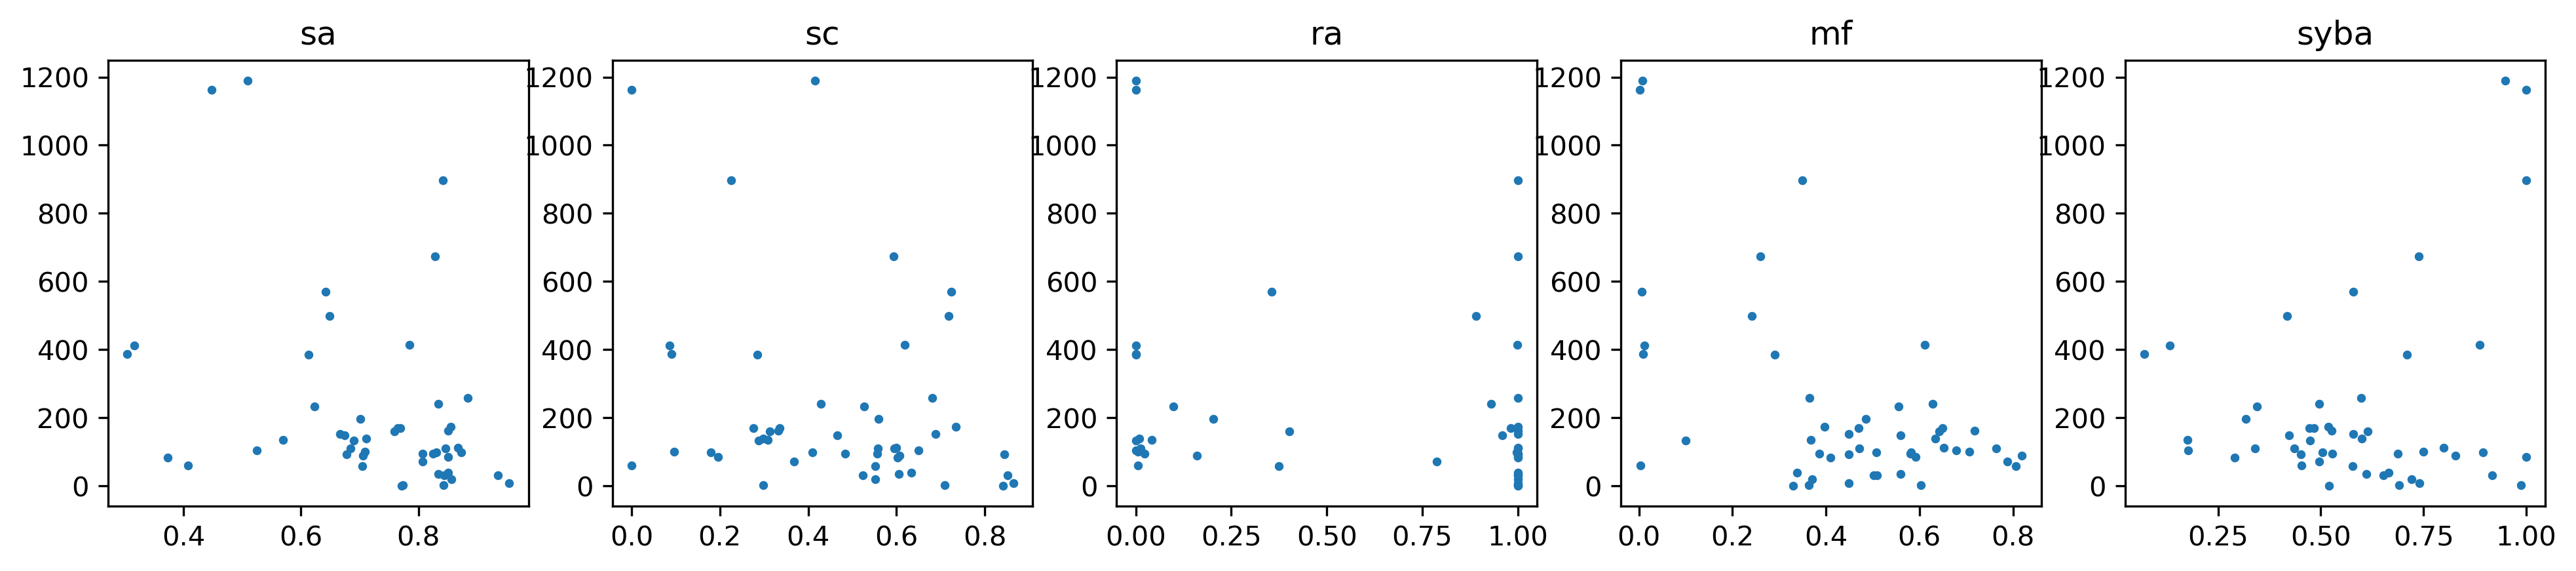

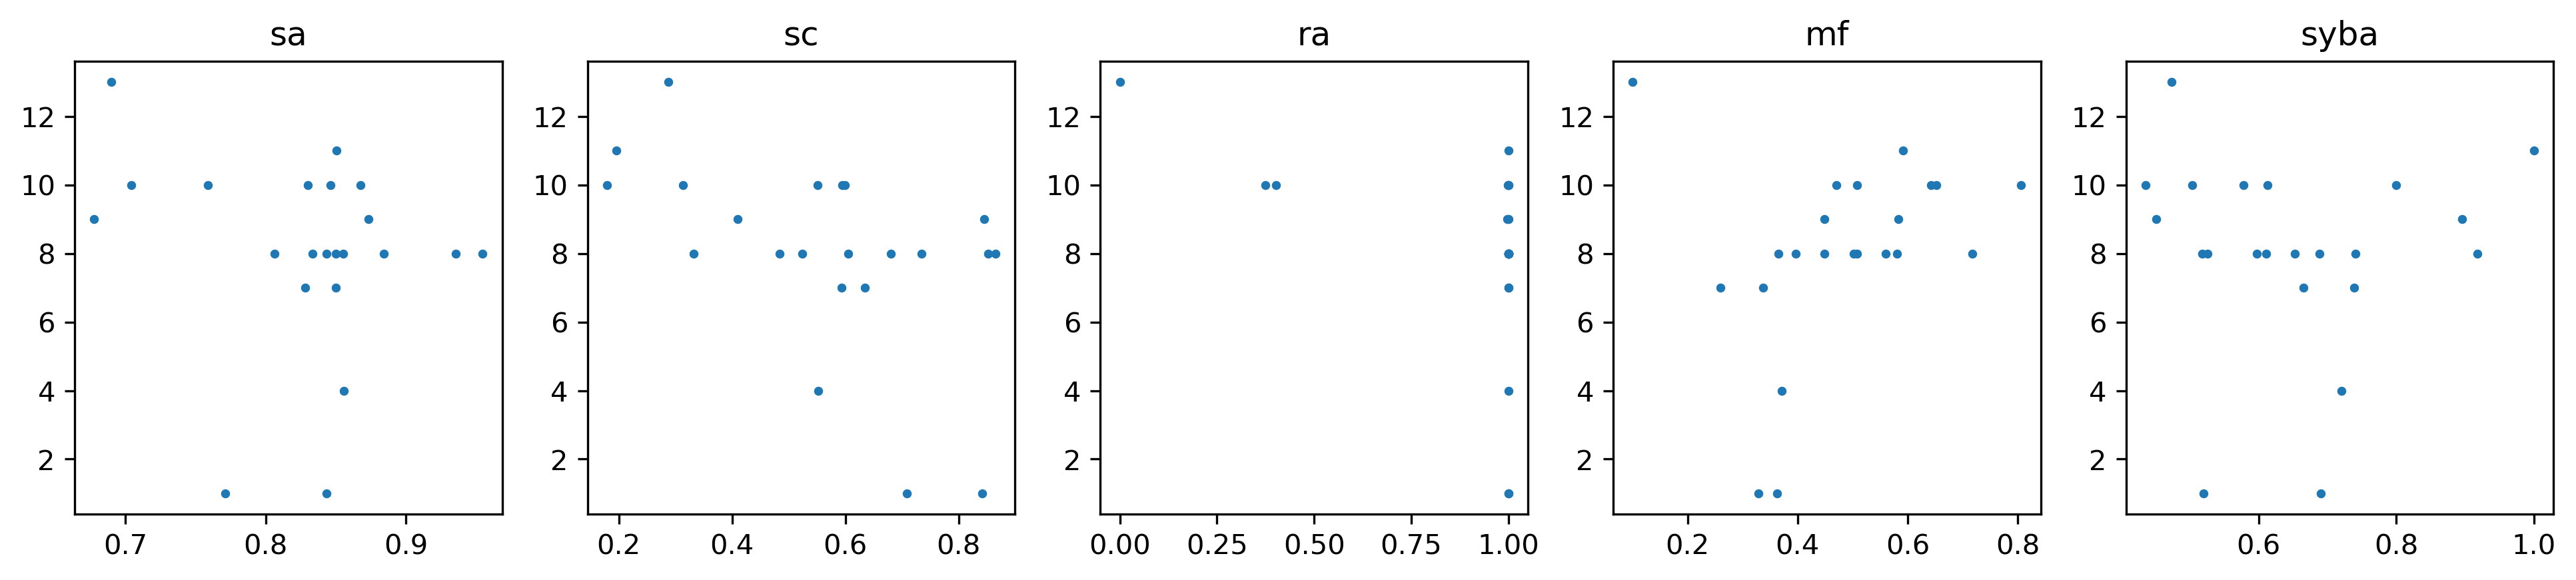

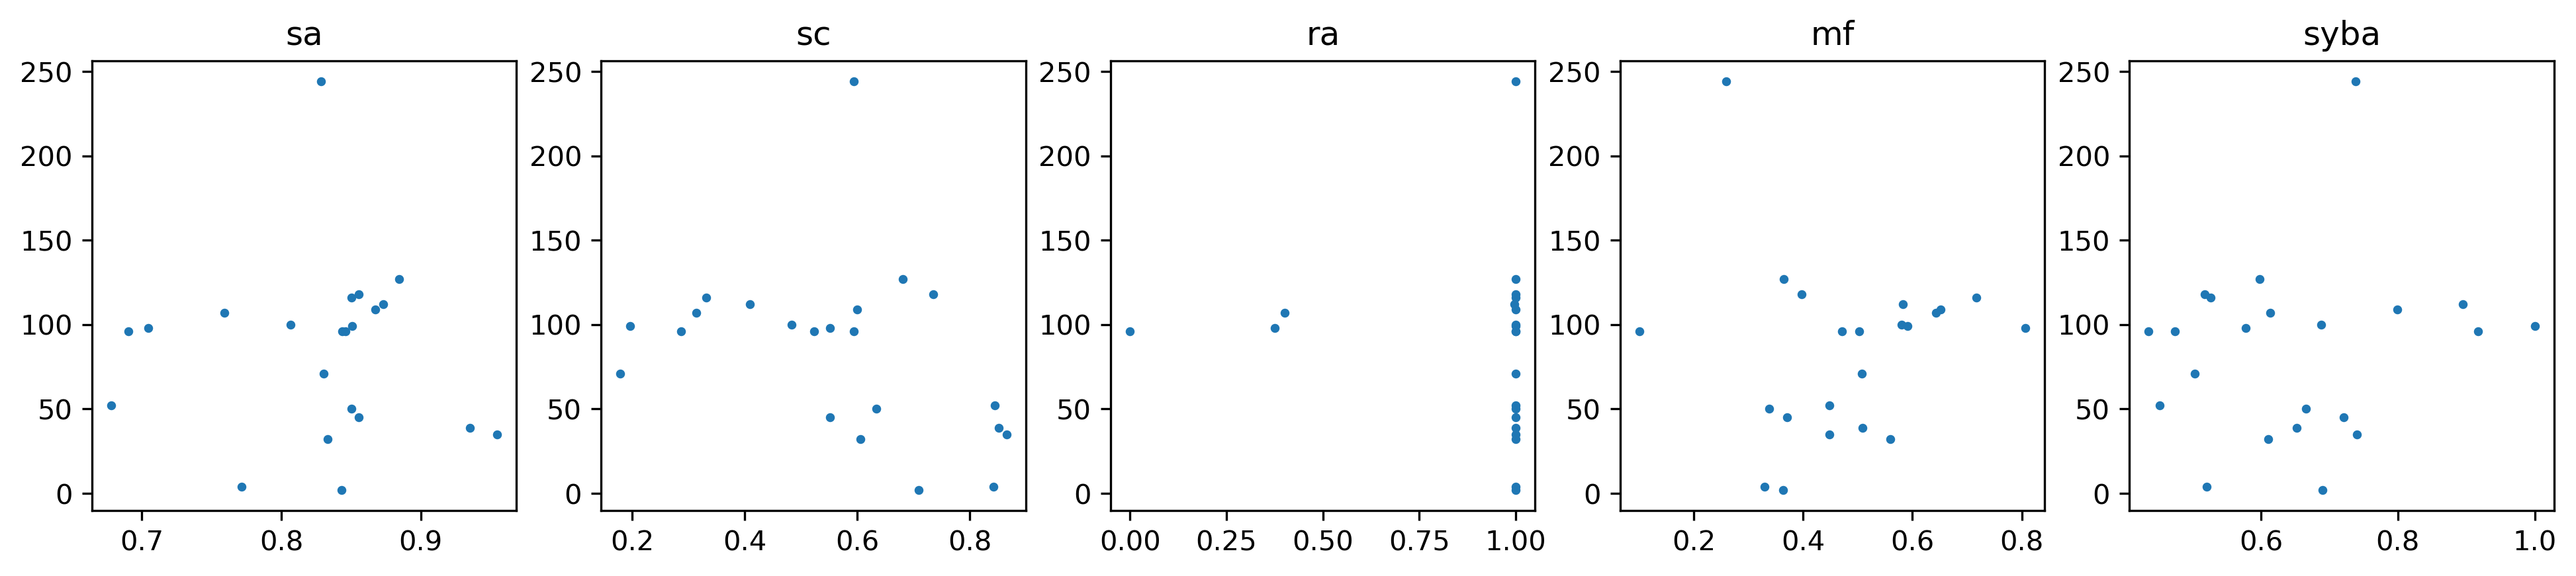

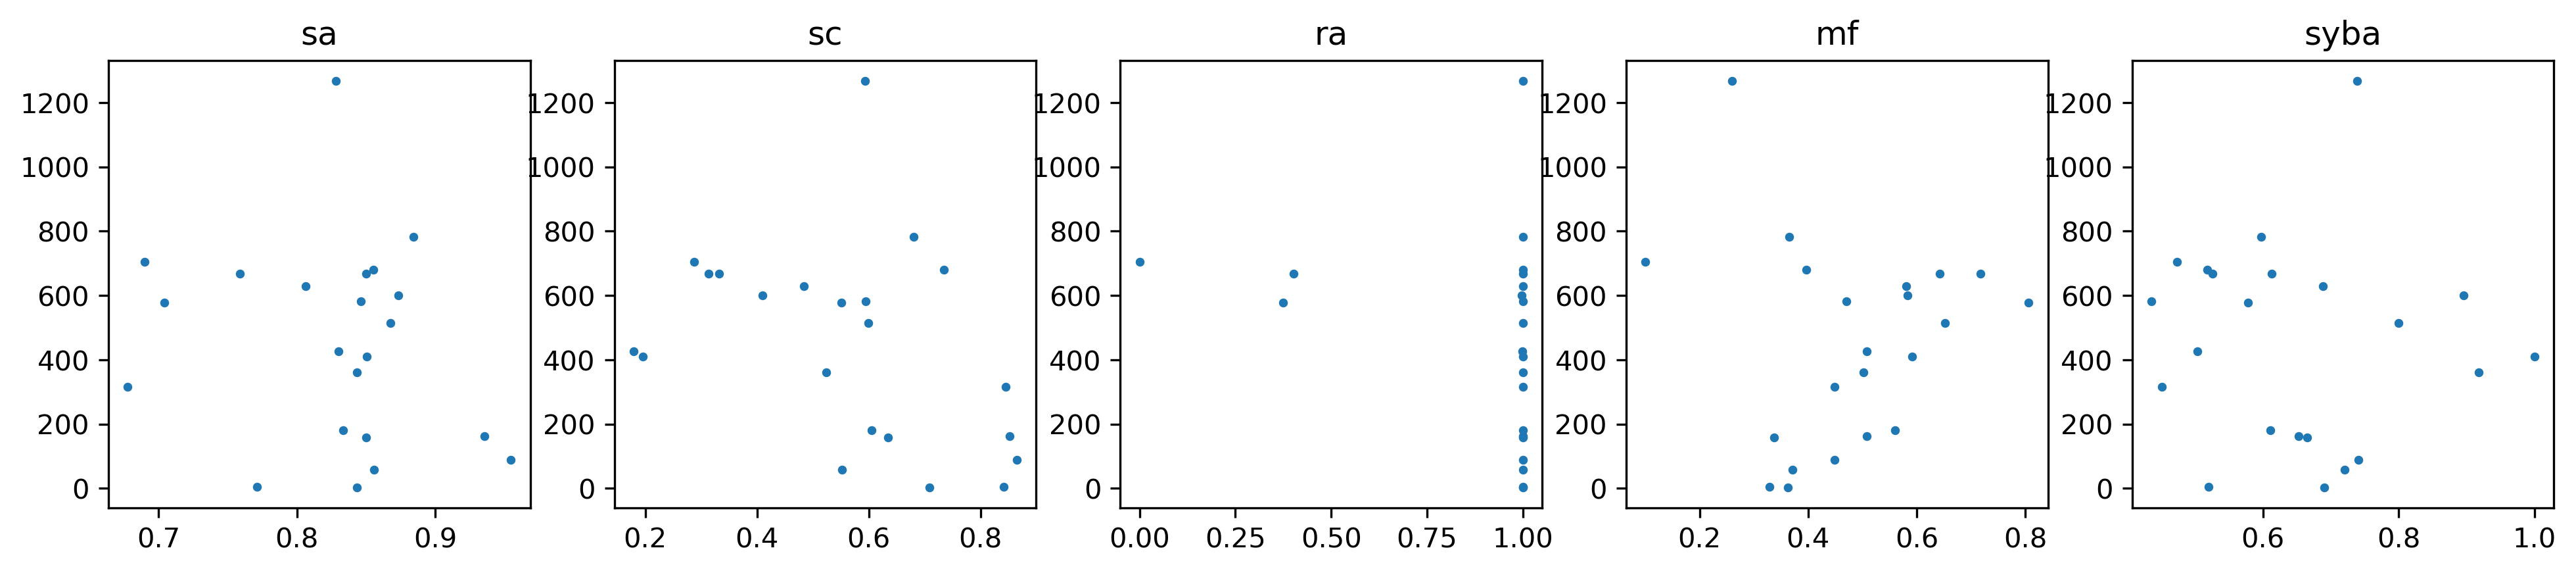

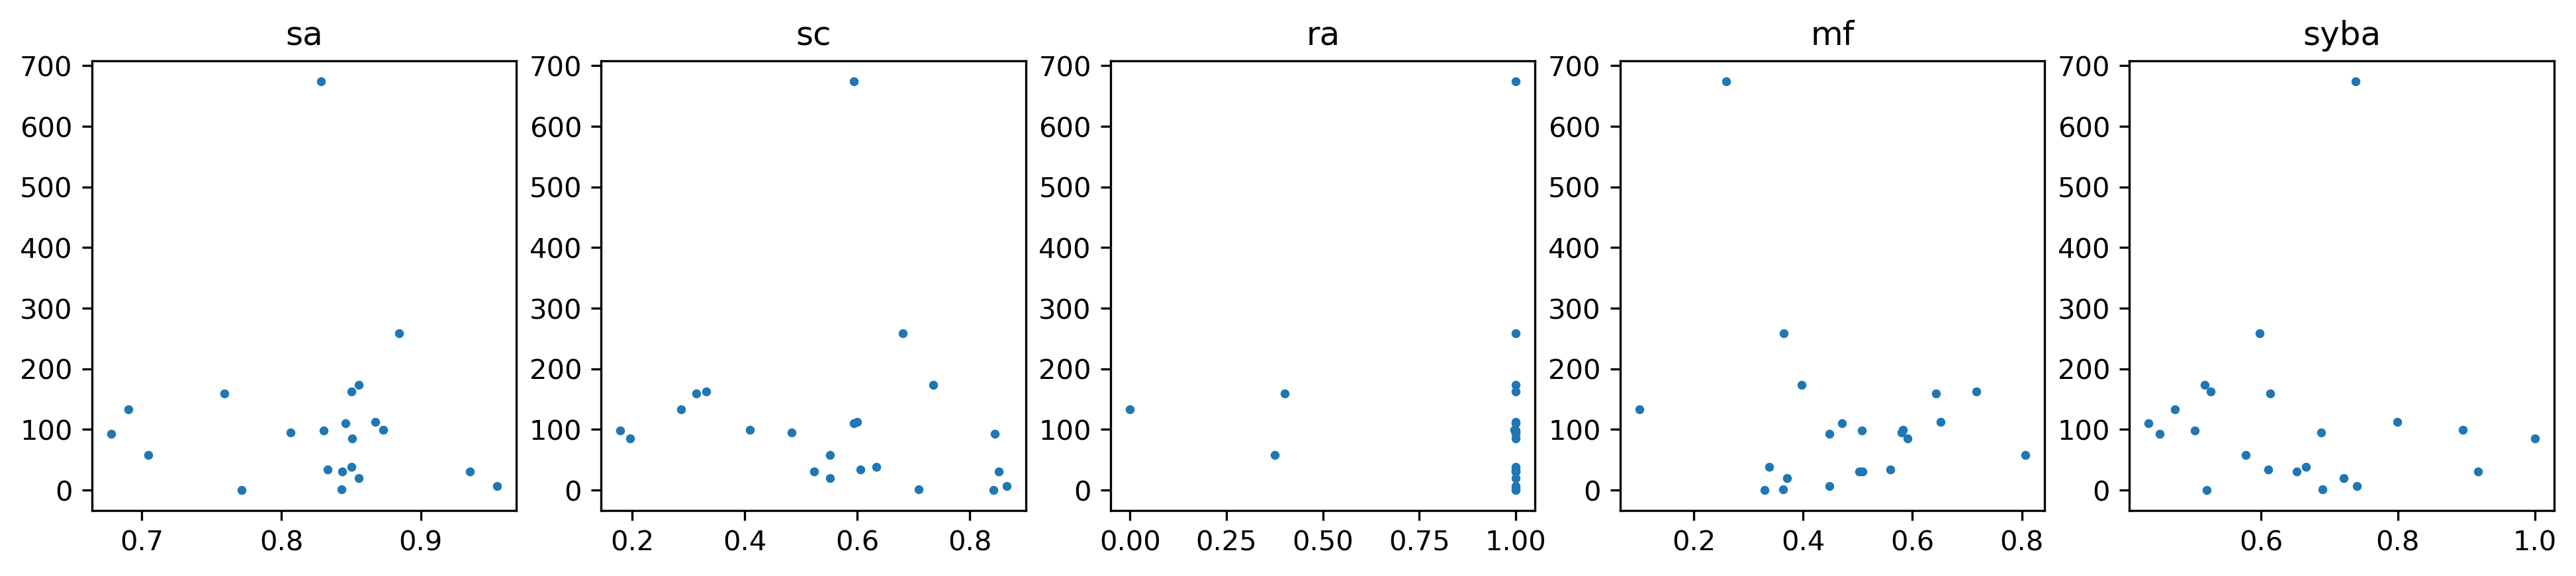

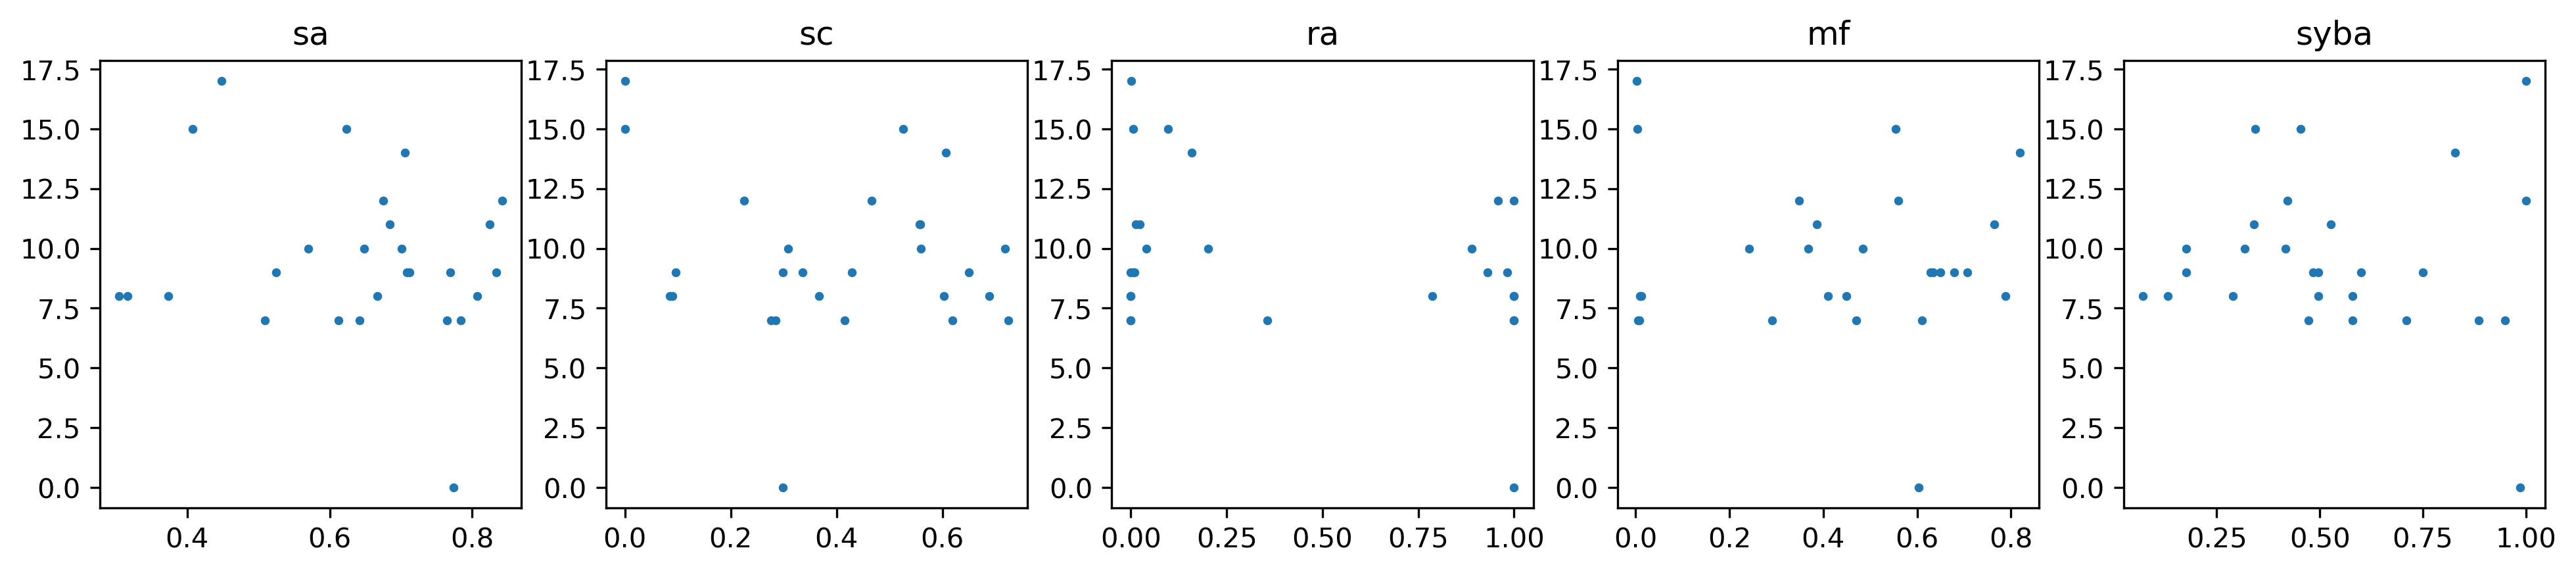

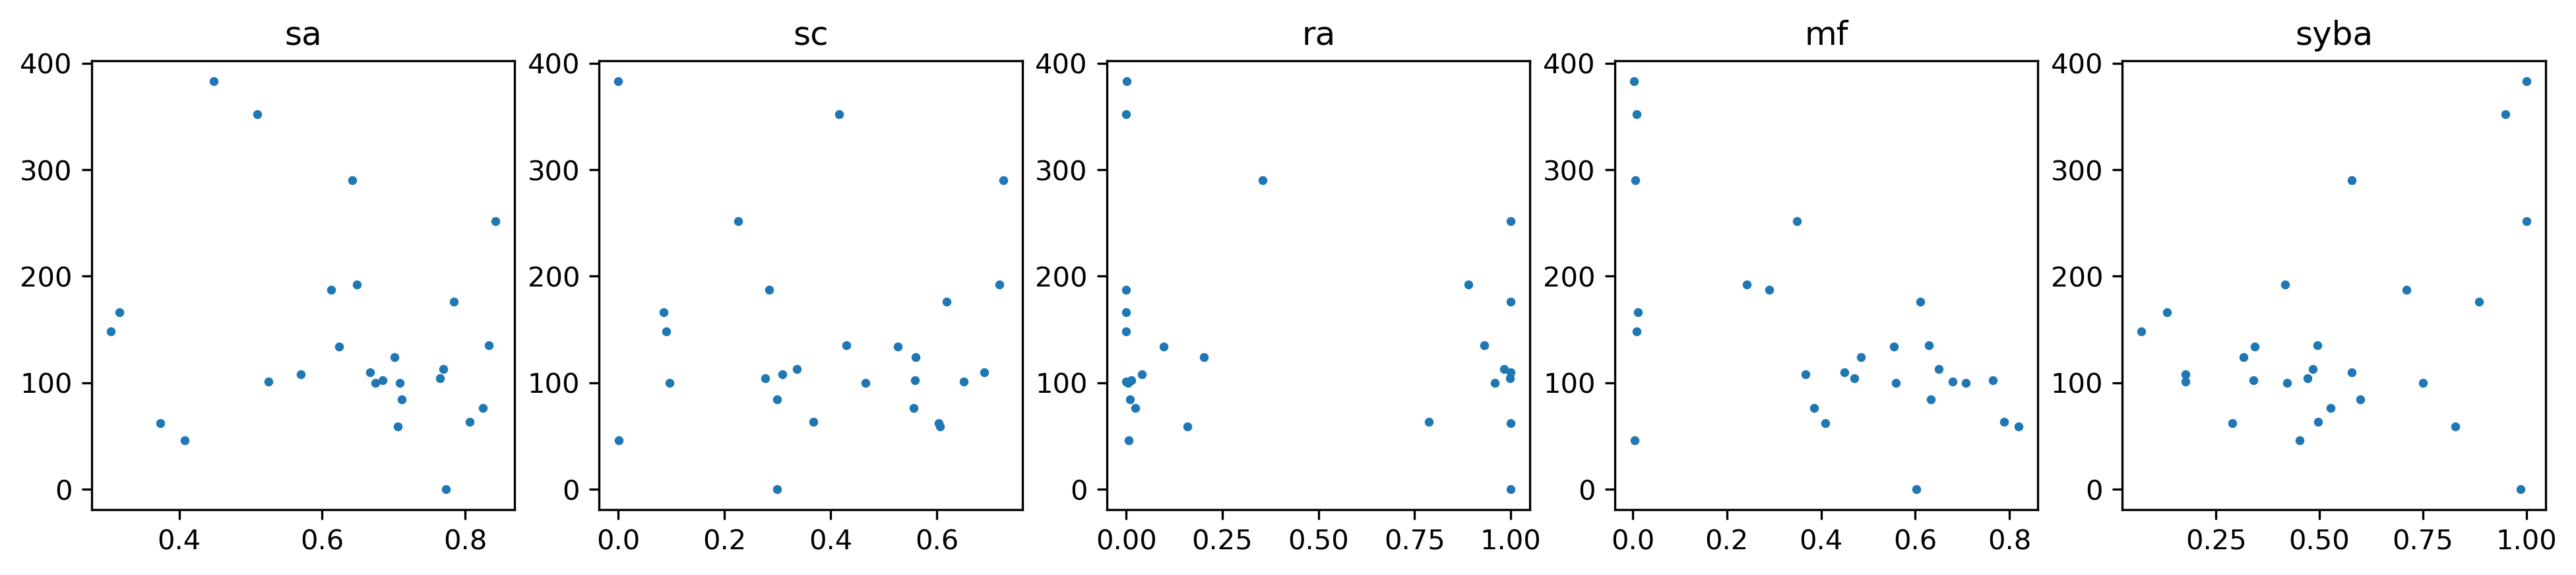

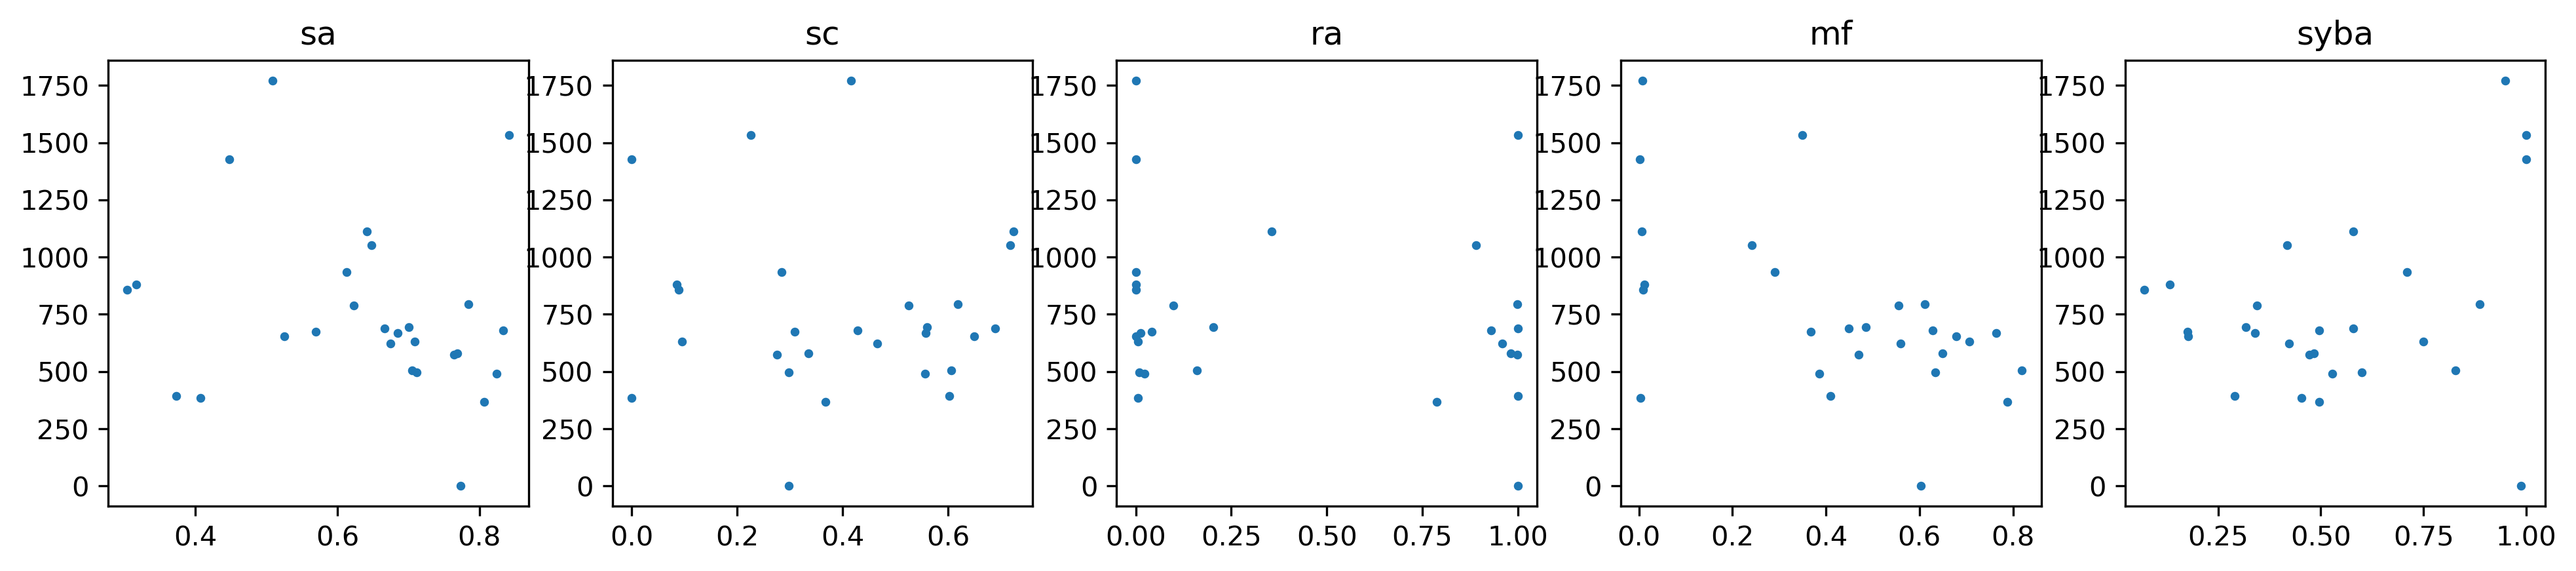

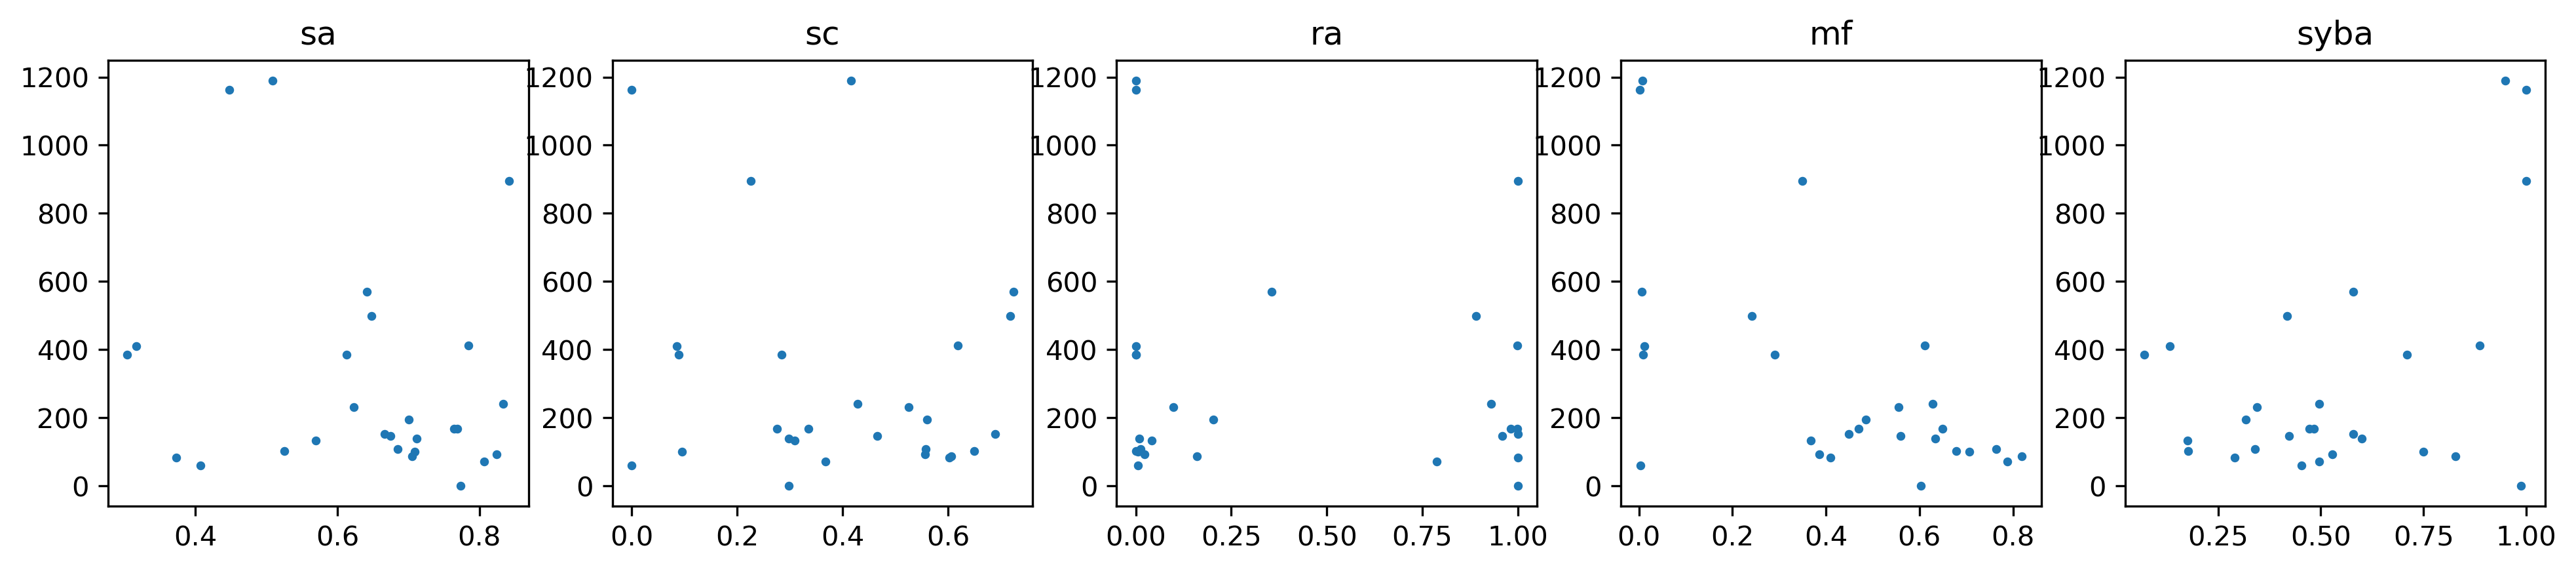

In [6]:

with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    for filter in filters:
        display(HTML("============================================="))
        display(HTML("filter: " + fn_txt(filter)))
        for characteristic in ("max_depth", "max_width", "node_count", "not_solved_count"):
            display(HTML(characteristic))
            rows: list[tuple[str, float,float,float]] = []
            pairs_score_characteristic: list[tuple[Score, int]] = [(score, stats[characteristic]) for score, type, stats in tree_stats if filter(type)]
            pairs_per_plot = []
            for score_name, getter in Score.getters():
#                 display(HTML(score_name))
                pairs_per_plot.append([(score_transformer(getter(score), score_name),
                                        char_value, score_name) for score, char_value in pairs_score_characteristic])
            scatter_plot(pairs_per_plot)

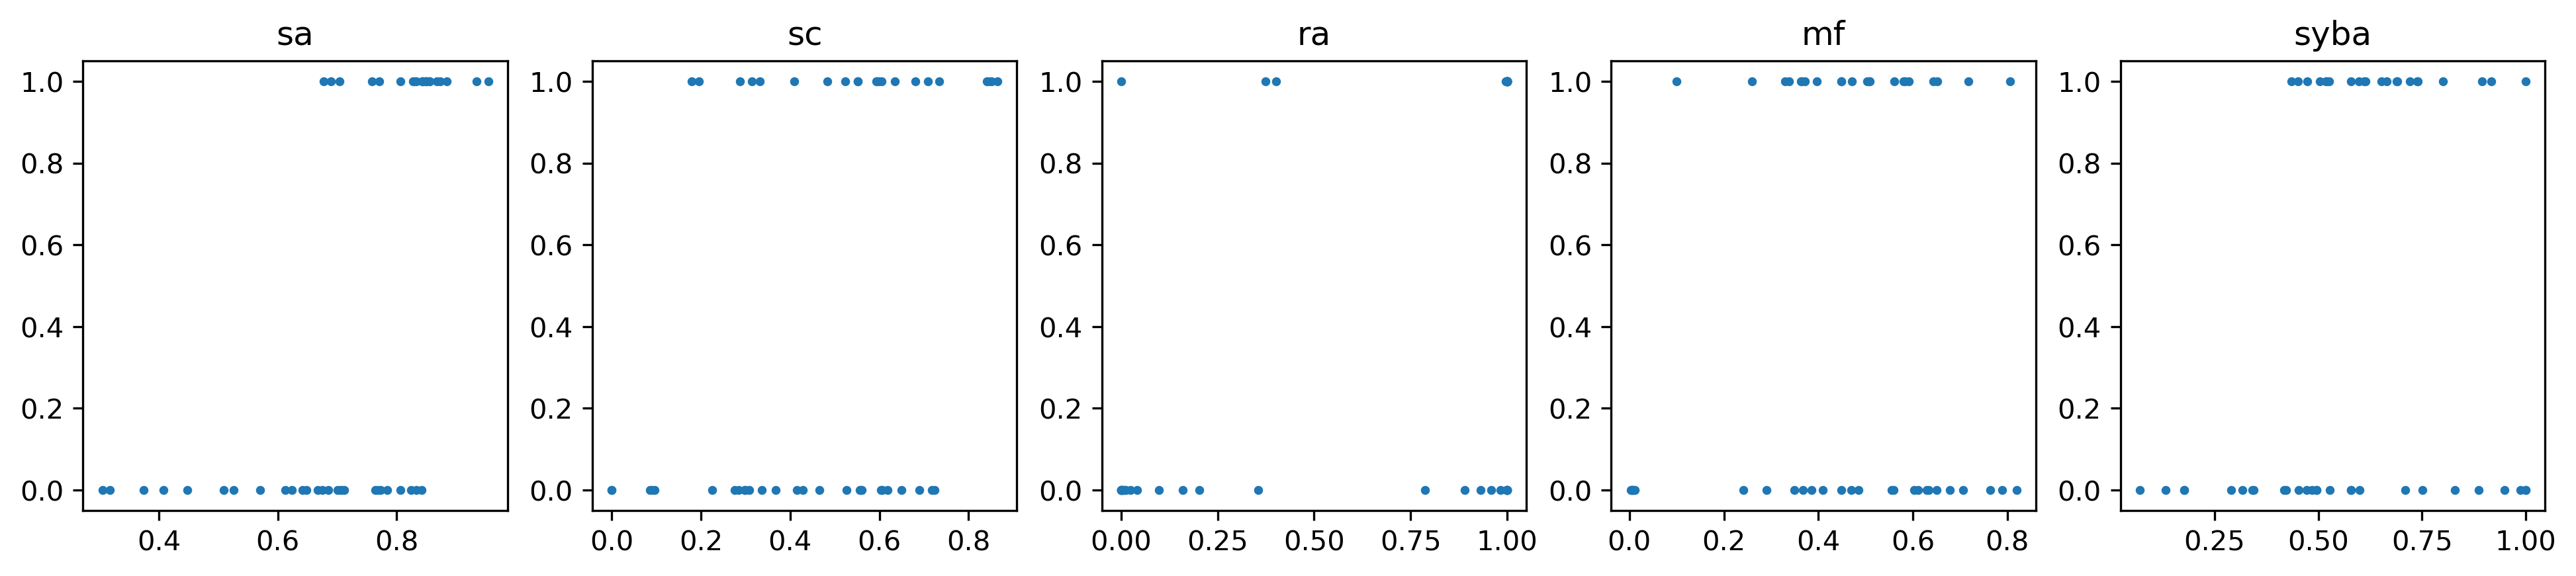

In [7]:
# The same but also checked just result of synthesis


with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]

    rows: list[tuple[str, float,float,float]] = []
    pairs_score_characteristic: list[tuple[Score, int]] = [(score, 
                                                            1 if type == "internal" else 0) for score, type, stats in tree_stats]
    pairs_per_plot = []
    for score_name, getter in Score.getters():

        pairs_per_plot.append([(score_transformer(getter(score), score_name),
                                char_value, score_name) for score, char_value in pairs_score_characteristic])
    scatter_plot(pairs_per_plot)

In [8]:
# Same as above with Spearman corr.

%load_ext autoreload
%autoreload 2

%matplotlib inline

from shared import Db, Fn

from main.ai import ai_setups, zero_setup
from main.data import Mol, data
from main.tree import JsonTree, Tree, TreeTypes
from main.types import AiInput, Setup
from main.score import Score

from IPython.display import display, HTML
from typing import Any

from scipy.stats import spearmanr

import numpy as np
import pandas
from main.utils import fn_txt


import matplotlib.pyplot as plt

def score_transformer(score_value: float, score_type: str) -> float:
    """Transform score so that fall within [0,1].

    0 means infeasible (not-accessible) molecule, 1 means fully feasible molecule.
    """
    if score_type == "sa":
        # Transform [1, 10] to [0,1] and invert
        result =  1 - (score_value - 1) / 9
    elif score_type == "sc":
        # Transform [1, 5] to [0,1] and invert
        result = 1 - (score_value - 1) / 9
    elif score_type == "ra":
        result = score_value
    elif score_type == "syba":
        # For now suppose it is within [-100, 100]
        result = (min(max(score_value, -100), 100) / 200) + 0.5
    elif score_type == "mf":
        # Transform [-800, 600] so that 0 turns into 0.5 (no inversion)
        truncated = min(max(score_value, -800), 600)
        if truncated > 0:
            truncated /= 2 * 600
        else:
            truncated /= 2 * 800
        result = truncated + 0.5
    else:
        result = score_value
    assert 0 <= result <= 1
    return result


def corr_row(pairs_per_plot: list[list[tuple[Any, Any, str]]]):
    result1 = []; result2 = []
    for i, pairs in enumerate(pairs_per_plot):
        xs = [x for x, _y, in pairs]
        ys = [y for _x, y, in pairs]
        corr = spearmanr(xs, ys, alternative="less")
        result1.append(corr.correlation)
        result2.append(corr.pvalue)
    return result1, result2


def get_stats(mol: Mol):
    ai_input: AiInput = {"smiles": mol.smiles, "setup": zero_setup}
    json_tree = db.read(["ai_postprocess", ai_input], JsonTree)
    assert json_tree
    tree = Tree(json_tree)
    assert len(tree.expandable) == 1
    assert len(tree.in_stock) == 0
    return tree.expandable[0].score, tree.type, tree.stats()

filters: list[Fn[TreeTypes, bool]] = [
    lambda _type: True,
    lambda type: type == "internal",
    lambda type: type == "not_solved"
]

with Db("db", True) as db:
    mols = data()
    tree_stats = [get_stats(mol) for mol in mols]
    for filter in filters:
        rows = [[""]]
        title = False
        display(HTML("============================================="))
        display(HTML("filter: " + fn_txt(filter)))
        for characteristic in ("max_depth", "max_width", "node_count", "not_solved_count"):
#             display(HTML(characteristic))
            pairs_score_characteristic: list[tuple[Score, int]] = [(score, stats[characteristic]) for score, type, stats in tree_stats if filter(type)]
            pairs_per_plot = []
            for score_name, getter in Score.getters():
                if not title: rows[0].append(score_name)
                pairs_per_plot.append([(score_transformer(getter(score), score_name),
                                        char_value) for score, char_value in pairs_score_characteristic])
            title = True
            first_row, second_row = corr_row(pairs_per_plot)
            rows.append([characteristic] + first_row)
            rows.append([""] + second_row)
        tab = tabulate.tabulate(rows, headers="firstrow",tablefmt='html')
        display(tab)
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,sa,sc,ra,mf,syba
max_depth,-0.213312,-0.308164,-0.353976,0.18846,-0.208161
,0.0705597,0.0156128,0.00629367,0.902654,0.0756024
max_width,-0.307308,-0.231476,-0.359088,-0.239743,-0.0277643
,0.015861,0.0547637,0.00564071,0.0485406,0.424902
node_count,-0.429767,-0.231083,-0.460435,-0.305424,-0.112877
,0.00102875,0.0550737,0.000435853,0.016419,0.219993
not_solved_count,-0.368651,-0.249662,-0.398804,-0.296196,-0.120637
,0.00457435,0.0418123,0.00226727,0.019392,0.204493


,sa,sc,ra,mf,syba
max_depth,-0.18233,-0.544078,-0.455099,0.502718,-0.188738
,0.20836,0.00442715,0.0166604,0.991451,0.200123
max_width,0.101187,-0.403053,-0.156382,0.271905,0.0797061
,0.672945,0.0314479,0.243535,0.889548,0.637804
node_count,-0.129342,-0.445072,-0.329861,0.125953,-0.207286
,0.283094,0.0189644,0.0669108,0.711755,0.177323
not_solved_count,-0.0491387,-0.369387,-0.241319,0.111268,-0.250777
,0.414043,0.0453338,0.139647,0.688981,0.130148


,sa,sc,ra,mf,syba
max_depth,-0.0262157,-0.0882083,-0.128631,0.0302252,-0.109677
,0.448363,0.330871,0.261274,0.559482,0.293022
max_width,-0.197832,-0.0155701,-0.175573,-0.543123,0.143228
,0.161296,0.46928,0.190524,0.00170834,0.761986
node_count,-0.296703,0.019536,-0.252175,-0.54884,0.116336
,0.0664401,0.538525,0.102227,0.00151557,0.718322
not_solved_count,-0.162113,-0.0351091,-0.13374,-0.537323,0.16827
,0.209583,0.43099,0.253009,0.00192495,0.799262
